In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

batch_size = 32
epochs = 10

# load the MNIST dataset
ds_train: tf.data.Dataset = tfds.load("mnist", split="train", shuffle_files=True)
ds_train = ds_train.repeat(epochs).shuffle(1024).batch(batch_size).prefetch(1)

/home/cris/jax-streams/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2022-12-17 22:53:22.396300: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


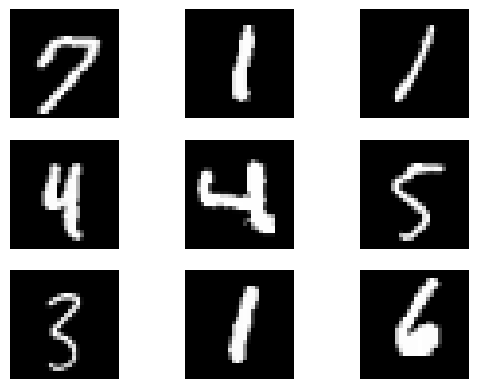

In [2]:
import matplotlib.pyplot as plt

samples = ds_train.as_numpy_iterator().next()
# plot a 3x3 grid of the images using subplots
fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(samples["image"][i * 3 + j, :, :, 0], cmap="gray")
        axs[i, j].axis("off")


In [3]:
import flax.linen as nn

class Classifier(nn.Module):
    num_classes: int
    
    @nn.compact
    def __call__(self, x):
        x = x / 255.0
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=self.num_classes)(x)
        return x

In [4]:

import jax
import jax.numpy as jnp

module = Classifier(num_classes=10)
variables = module.init(jax.random.PRNGKey(0), jnp.empty((1, 28, 28, 1)))
params = variables['params']
print(jax.tree_map(jnp.shape, params))

FrozenDict({
    Dense_0: {
        bias: (10,),
        kernel: (784, 10),
    },
})


In [5]:
print(module.tabulate(jax.random.PRNGKey(0), jnp.empty((1, 28, 28, 1))))


                               Classifier Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module     ┃ inputs            ┃ outputs       ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ Classifier │ float32[1,28,28,… │ float32[1,10] │                   │
├─────────┼────────────┼───────────────────┼───────────────┼───────────────────┤
│ Dense_0 │ Dense      │ float32[1,784]    │ float32[1,10] │ bias: float32[10] │
│         │            │                   │               │ kernel:           │
│         │            │                   │               │ float32[784,10]   │
│         │            │                   │               │                   │
│         │            │                   │               │ 7,850 (31.4 KB)   │
├─────────┼────────────┼───────────────────┼───────────────┼───────────────────┤
│         │            │   

In [6]:
from flax.training.train_state import TrainState
import optax

def create_state(module):
    variables = module.init(jax.random.PRNGKey(0), jnp.empty((1, 28, 28, 1)))
    return TrainState.create(
        apply_fn=module.apply,
        params=variables["params"],
        tx=optax.adamw(1e-3),
    )

In [22]:
state = create_state(module)
print(jax.tree_map(jnp.shape, state))

TrainState(step=(), apply_fn=<bound method Module.apply of Classifier(
    # attributes
    num_classes = 10
)>, params=FrozenDict({
    Dense_0: {
        bias: (10,),
        kernel: (784, 10),
    },
}), tx=GradientTransformation(init=<function chain.<locals>.init_fn at 0x7f28082b2160>, update=<function chain.<locals>.update_fn at 0x7f28082b2550>), opt_state=(ScaleByAdamState(count=(), mu=FrozenDict({
    Dense_0: {
        bias: (10,),
        kernel: (784, 10),
    },
}), nu=FrozenDict({
    Dense_0: {
        bias: (10,),
        kernel: (784, 10),
    },
})), EmptyState(), EmptyState()))


In [14]:
from typing import Dict

def loss_fn(params, apply_fn, batch):
    logits = apply_fn({'params': params}, x=batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']
    ).mean()
    return loss, logits

@jax.jit
def train_step(state: TrainState, batch: Dict[str, jax.Array]):
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params, state.apply_fn, batch)

    state = state.apply_gradients(grads=grads)

    logs = {
        'loss': loss,
        'accuracy': (jnp.argmax(logits, axis=-1) == batch['label']).mean()
    }
    return logs, state

In [26]:
from tqdm import tqdm
import numpy as np

state = create_state(module)
history = []
total_steps = ds_train.cardinality().numpy()

for batch in tqdm(ds_train.as_numpy_iterator(), total=total_steps):
    logs, state = train_step(state, batch)
    logs = jax.tree_map(np.asarray, logs)
    history.append(logs)

100%|██████████| 18750/18750 [00:30<00:00, 622.58it/s]


Text(0.5, 1.0, 'Accuracy')

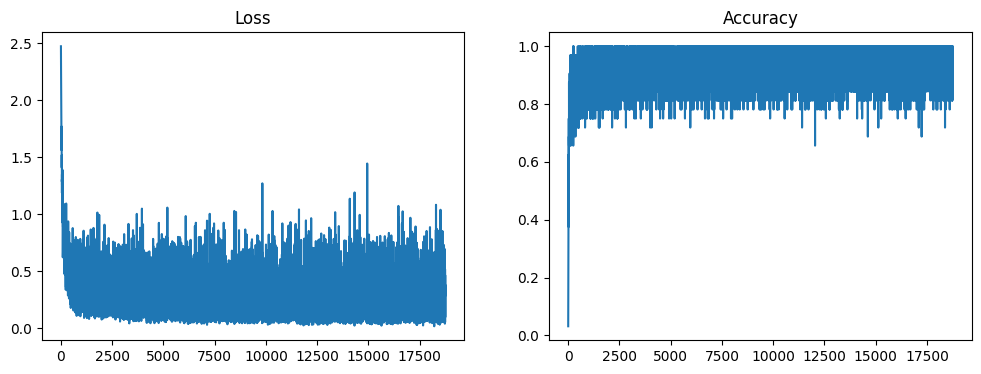

In [28]:

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot([h['loss'] for h in history])
axs[0].set_title('Loss')
axs[1].plot([h['accuracy'] for h in history])
axs[1].set_title('Accuracy')